In [1]:
from astropy.io import fits
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u

In [2]:
#load in apogee file
file='astraAllStarASPCAP-0.6.0.fits'
hdul=fits.open(file)
data=hdul[2].data
apogee_table = Table(data)

In [3]:
#https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/673/A114#/browse
#load in cluster file
cluster_file = 'J_A+A_673_A114_clusters.dat.gz.fits' 
hdu=fits.open(cluster_file)
cluster_data=hdu[1].data
cluster_table = Table(cluster_data)

In [4]:
apogee_table_new = apogee_table[['tic_v8_id','ra','dec']] # values needed
apogee_table_df = apogee_table_new.to_pandas()
apogee_table_df = apogee_table_df.dropna() # easier to remove any nan values this way
apogee_table_new = Table.from_pandas(apogee_table_df)

In [5]:
cluster_table_new = cluster_table[['Name','RAdeg','DEdeg','r50','logAge50']] # values need, can remove logAge50 actuallly

In [6]:
# create new column that has the ra,dec but in SkyCoord format for easier use
cluster_coords = SkyCoord(ra=cluster_table_new['RAdeg']*u.deg, dec=cluster_table_new['DEdeg']*u.deg)
cluster_column = Column(name='coordinates', data=cluster_coords)
cluster_table_new.add_column(cluster_column)
 
star_coords = SkyCoord(ra=apogee_table_new['ra']*u.deg, dec=apogee_table_new['dec']*u.deg)
star_column = Column(name='coordinates', data=star_coords)
apogee_table_new.add_column(star_column)


In [7]:
cluster_radius = cluster_table['r50']
cluster_radius_np = np.array(cluster_radius * u.deg) # put in array for <=

# matching star coordinates to cluster coordinates
# get back index, angular separation, physical separation
index, ang_sep, p_sep = match_coordinates_sky(star_coords, cluster_coords)
ang_sep_deg = ang_sep.degree

is_in_cluster = ang_sep_deg <= cluster_radius[index]

In [8]:
# new dataframe for apogee data
star_clusters = pd.DataFrame({
    'tic_v8_id': apogee_table_new['tic_v8_id'],
    'ra': apogee_table_new['ra'],
    'dec': apogee_table_new['dec'],
    'cluster_name': cluster_table_new['Name'][index],
    'cluster_age': cluster_table_new['logAge50'][index],
    'is_in_cluster': is_in_cluster
})
# last column will return true/false

# get only true values
stars_in_clusters = star_clusters[star_clusters['is_in_cluster']]

In [9]:
# same as binary matcher
def cluster_matcher(csv_file):
    tic_ages = pd.read_csv(csv_file)
    tic_cluster = stars_in_clusters[stars_in_clusters['tic_v8_id'].isin(tic_ages['TIC'])].copy()
    tic_ages = tic_ages.drop_duplicates(subset='TIC')
    tic_cluster = tic_cluster.drop_duplicates(subset='tic_v8_id')
    merged = pd.merge(tic_cluster, tic_ages, left_on='tic_v8_id', right_on='TIC', how='inner')
    return merged

In [10]:
# find clusters in each data set
tess_apokasc2_clusters = cluster_matcher('TESS_APOKASC2_Comparison.csv')
tess_apokasc3_clusters = cluster_matcher('TESS_APOKASC3_Comparison.csv')
tess_apok2_clusters = cluster_matcher('TESS_APOK2_Comparison.csv')


In [11]:
# reconfiguring cluster sets to get columns needed and changing column names

apokasc2_ages_old = tess_apokasc2_clusters[['tic_v8_id', 'APOKASC2_predicted_Gyr','cluster_name']]
apokasc2_ages = apokasc2_ages_old.rename(columns={'APOKASC2_predicted_Gyr': 'predicted_ages'})

apokasc3_ages_old = tess_apokasc3_clusters[['tic_v8_id','APOKASC3_predicted_Gyr', 'cluster_name']]
apokasc3_ages = apokasc3_ages_old.rename(columns={'APOKASC3_predicted_Gyr': 'predicted_ages'})

apok2_ages_old = tess_apok2_clusters[['tic_v8_id','APOK2_predicted_Gyr', 'cluster_name']]
apok2_ages = apok2_ages_old.rename(columns={'APOK2_predicted_Gyr': 'predicted_ages'})

tess1_ages_old = tess_apokasc2_clusters[['tic_v8_id','TESS_predicted_Gyr', 'cluster_name']]
tess1_ages = tess1_ages_old.rename(columns={'TESS_predicted_Gyr': 'predicted_ages'})

tess2_ages_old = tess_apokasc3_clusters[['tic_v8_id','TESS_predicted_Gyr', 'cluster_name']]
tess2_ages = tess1_ages_old.rename(columns={'TESS_predicted_Gyr': 'predicted_ages'})

tess3_ages_old = tess_apok2_clusters[['tic_v8_id','TESS_predicted_Gyr', 'cluster_name']]
tess3_ages = tess1_ages_old.rename(columns={'TESS_predicted_Gyr': 'predicted_ages'})

In [12]:
# have to average out tess age findings because they are done in all three csv files but also differ slightly
# same with binaries
tess_c1 = tess1_ages.set_index('tic_v8_id')
tess_c2 = tess2_ages.set_index('tic_v8_id')
tess_c3 = tess3_ages.set_index('tic_v8_id')
tess_avg = (tess_c1['predicted_ages'] + tess_c2['predicted_ages'] + tess_c3['predicted_ages'])/3
combined_tess = pd.DataFrame({'predicted_ages': tess_avg, 
                              'cluster_name': tess_c1['cluster_name']})
tess_ages = combined_tess.reset_index()

In [13]:
# calculating the dispersion in ages in each cluster in the data sets
def age_dispersion(dataset):
    first_results = dataset.groupby('cluster_name', as_index=False)['predicted_ages'].agg(['mean', 'std'])
    new_results = first_results.dropna() # removes NaN, applies for clusters with only 1 star assigned
    return new_results

In [14]:
tess_dispersion = age_dispersion(tess_ages)
apokasc2_dispersion = age_dispersion(apokasc2_ages)
apokasc3_dispersion = age_dispersion(apokasc3_ages)
apok2_dispersion = age_dispersion(apok2_ages)


In [15]:
# makes several plots
def plot_maker(data_dispersion, data_name):
    # divide each data set into a smaller piece to graph 
    dispersion_sets = []
    twelfth = len(data_dispersion)/12
    index_12 = [int(i*twelfth) for i in range(12)]
    for j in range(len(index_12)-1):
        subset = data_dispersion.iloc[index_12[j]:index_12[j+1]]
        dispersion_sets.append(subset)
    last_subset = data_dispersion.iloc[index_12[-1]:]
    dispersion_sets.append(last_subset)
    
    # 12 subplots, each showing 167 clusters
    fig, axes = plt.subplots(12, 1, figsize=(40, 96), layout='constrained')
    axes = axes.flatten()
    for i, data in enumerate(dispersion_sets):
        ax = axes[i]
        x = data['cluster_name']
        x_pos = np.arange(len(x))
        ax.errorbar(x_pos, data['mean'], yerr=data['std'], fmt='o', color='blue', ecolor='gray', elinewidth=2, capsize=5)
        ax.set_xlabel('Cluster Name')
        ax.set_ylabel('Mean Age (Gyr)')
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x)
        ax.set_xlim(-0.7, len(x) - 0.2)

    plt.suptitle(f'Age Dispersion of Star in Clusters using {data_name}')
    #plt.savefig(f'{data_name}_dispersion_plot.pdf') #can save as pdf if you want
    plt.show()

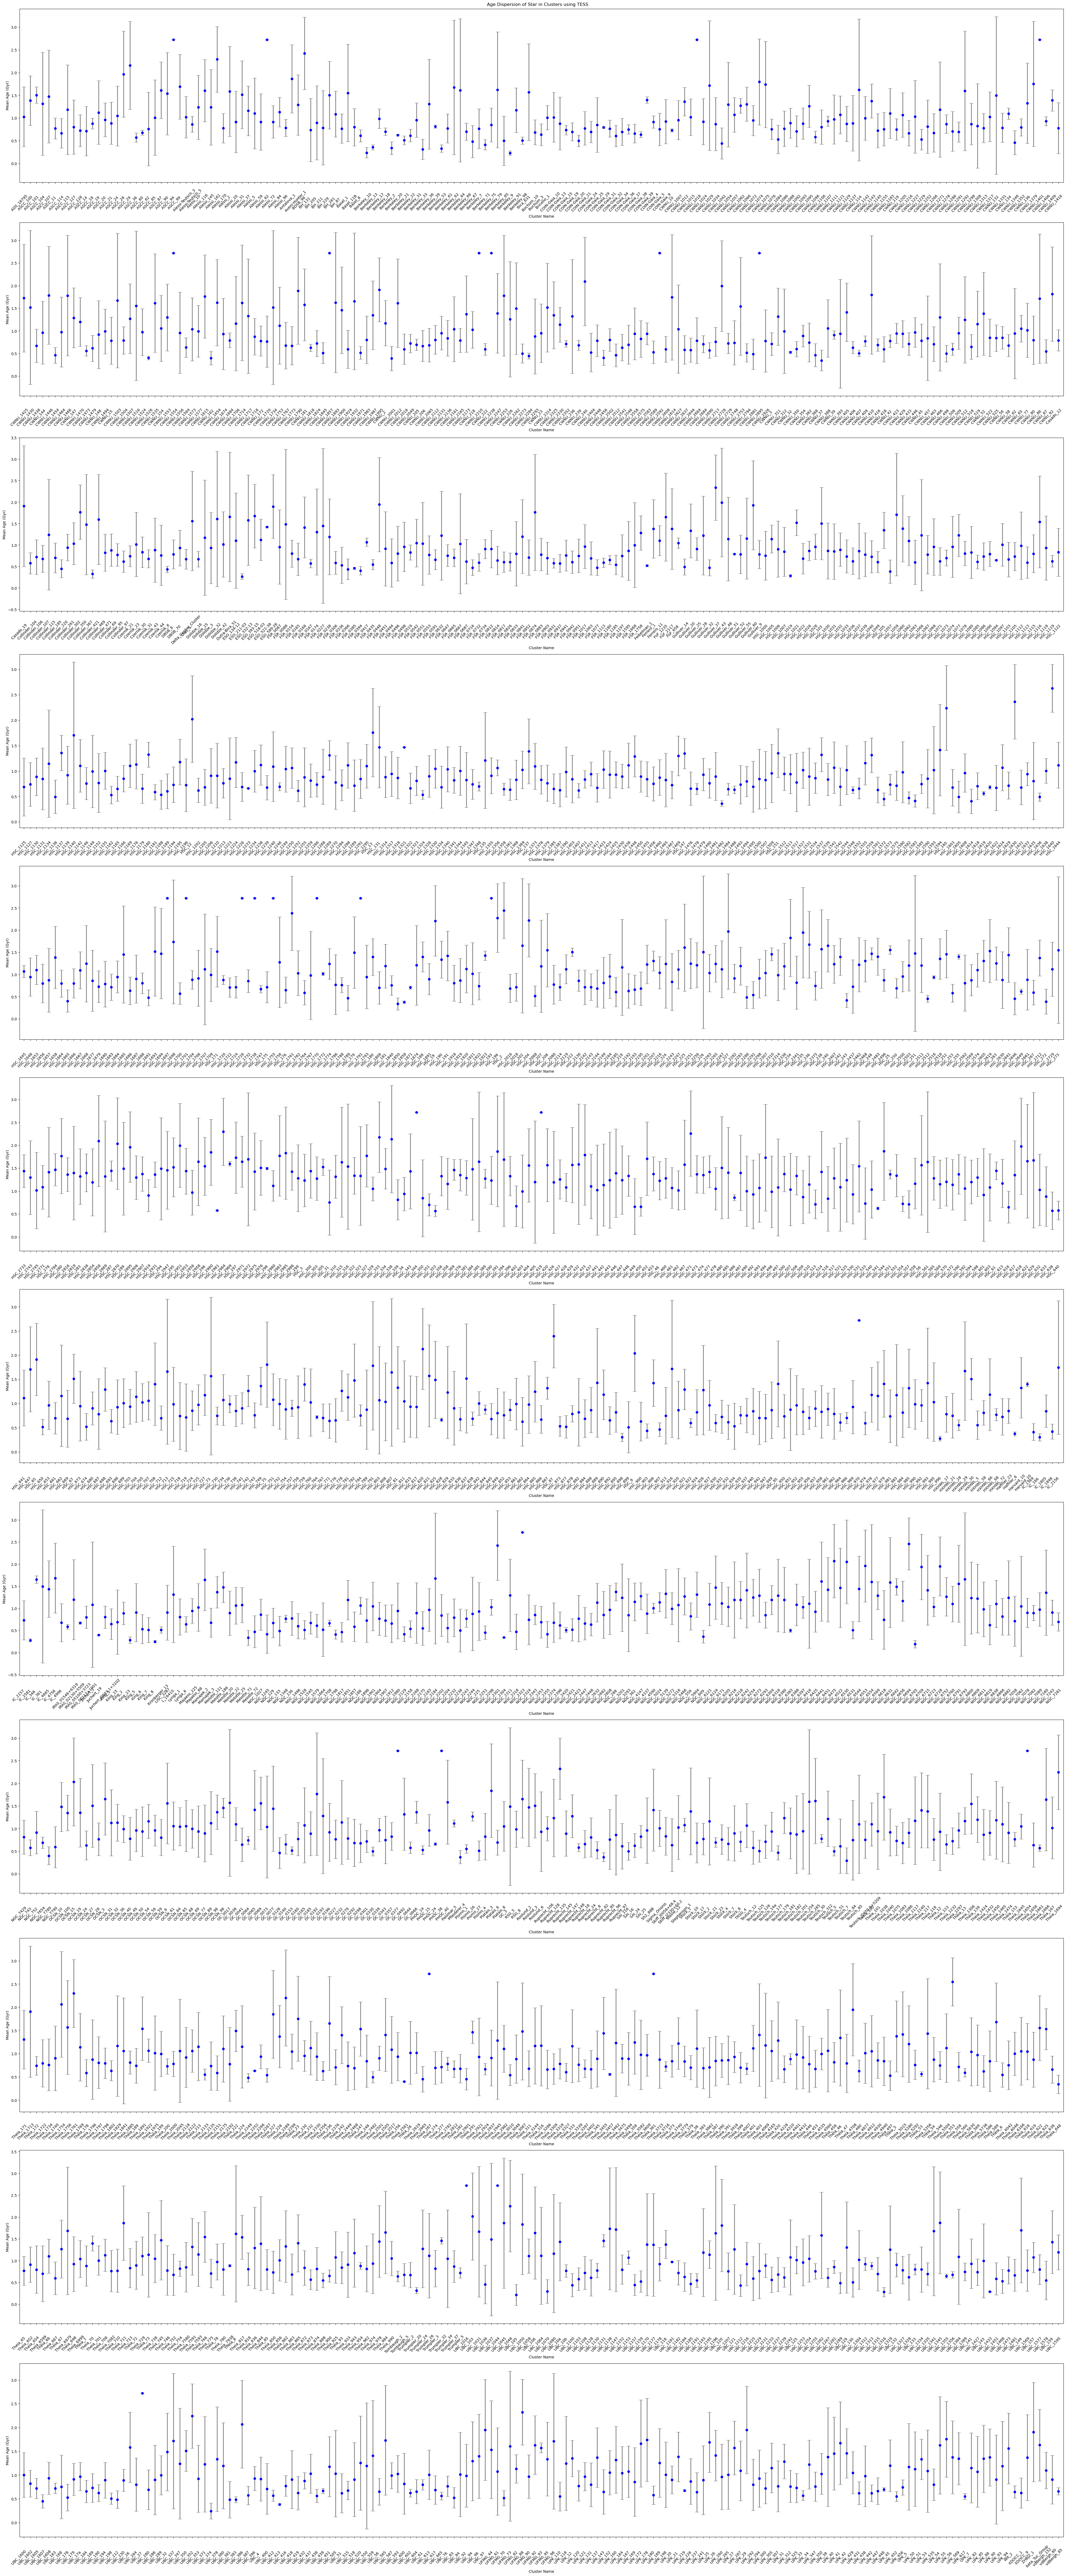

In [16]:
plot_maker(tess_dispersion, 'TESS')

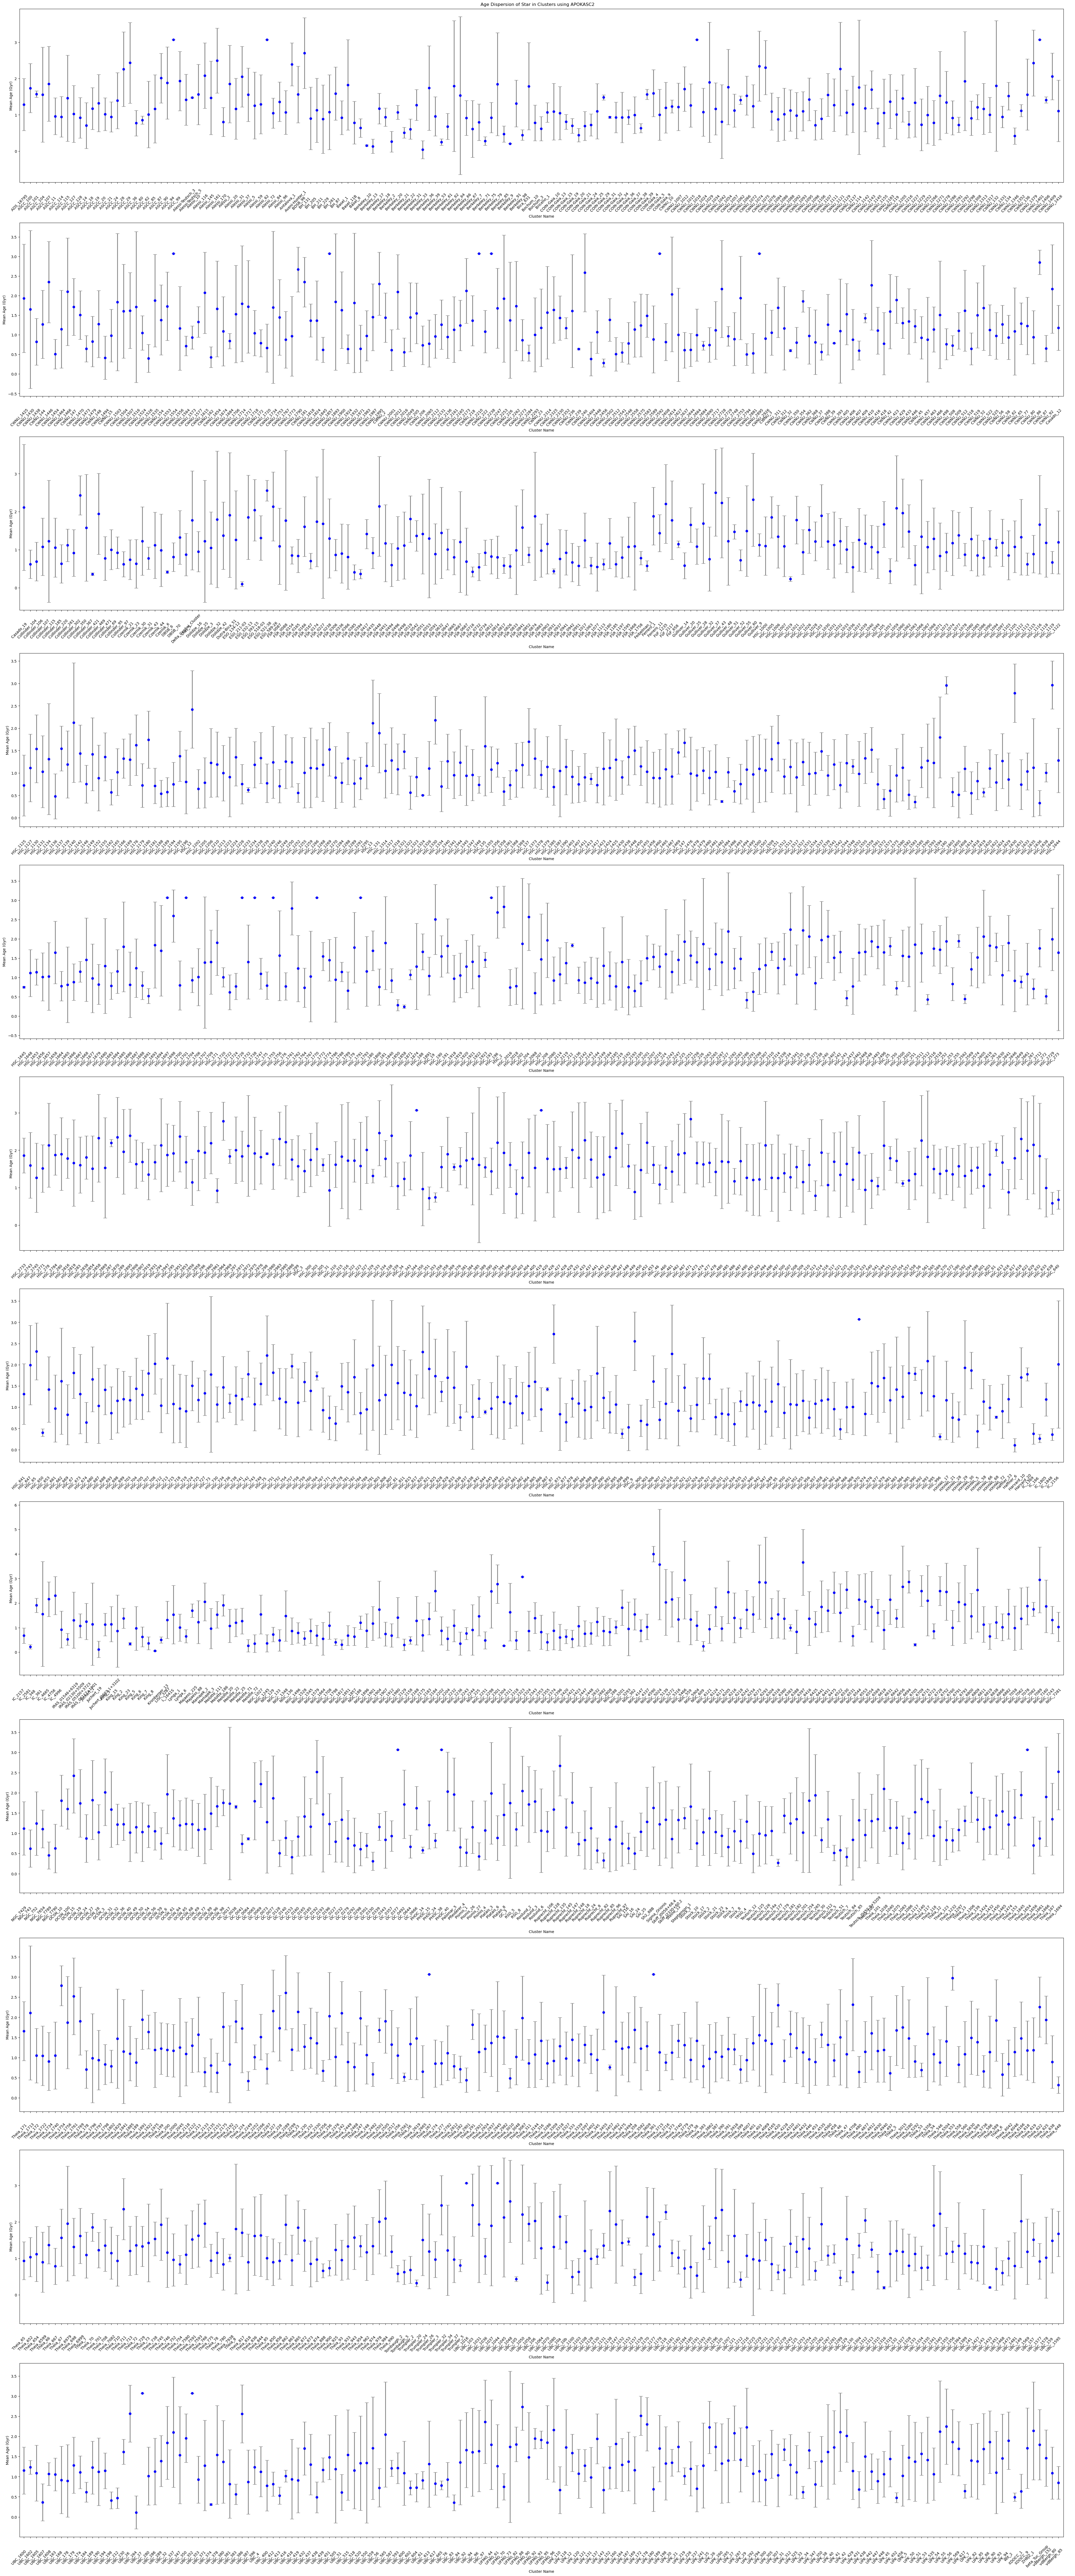

In [17]:
plot_maker(apokasc2_dispersion, 'APOKASC2')

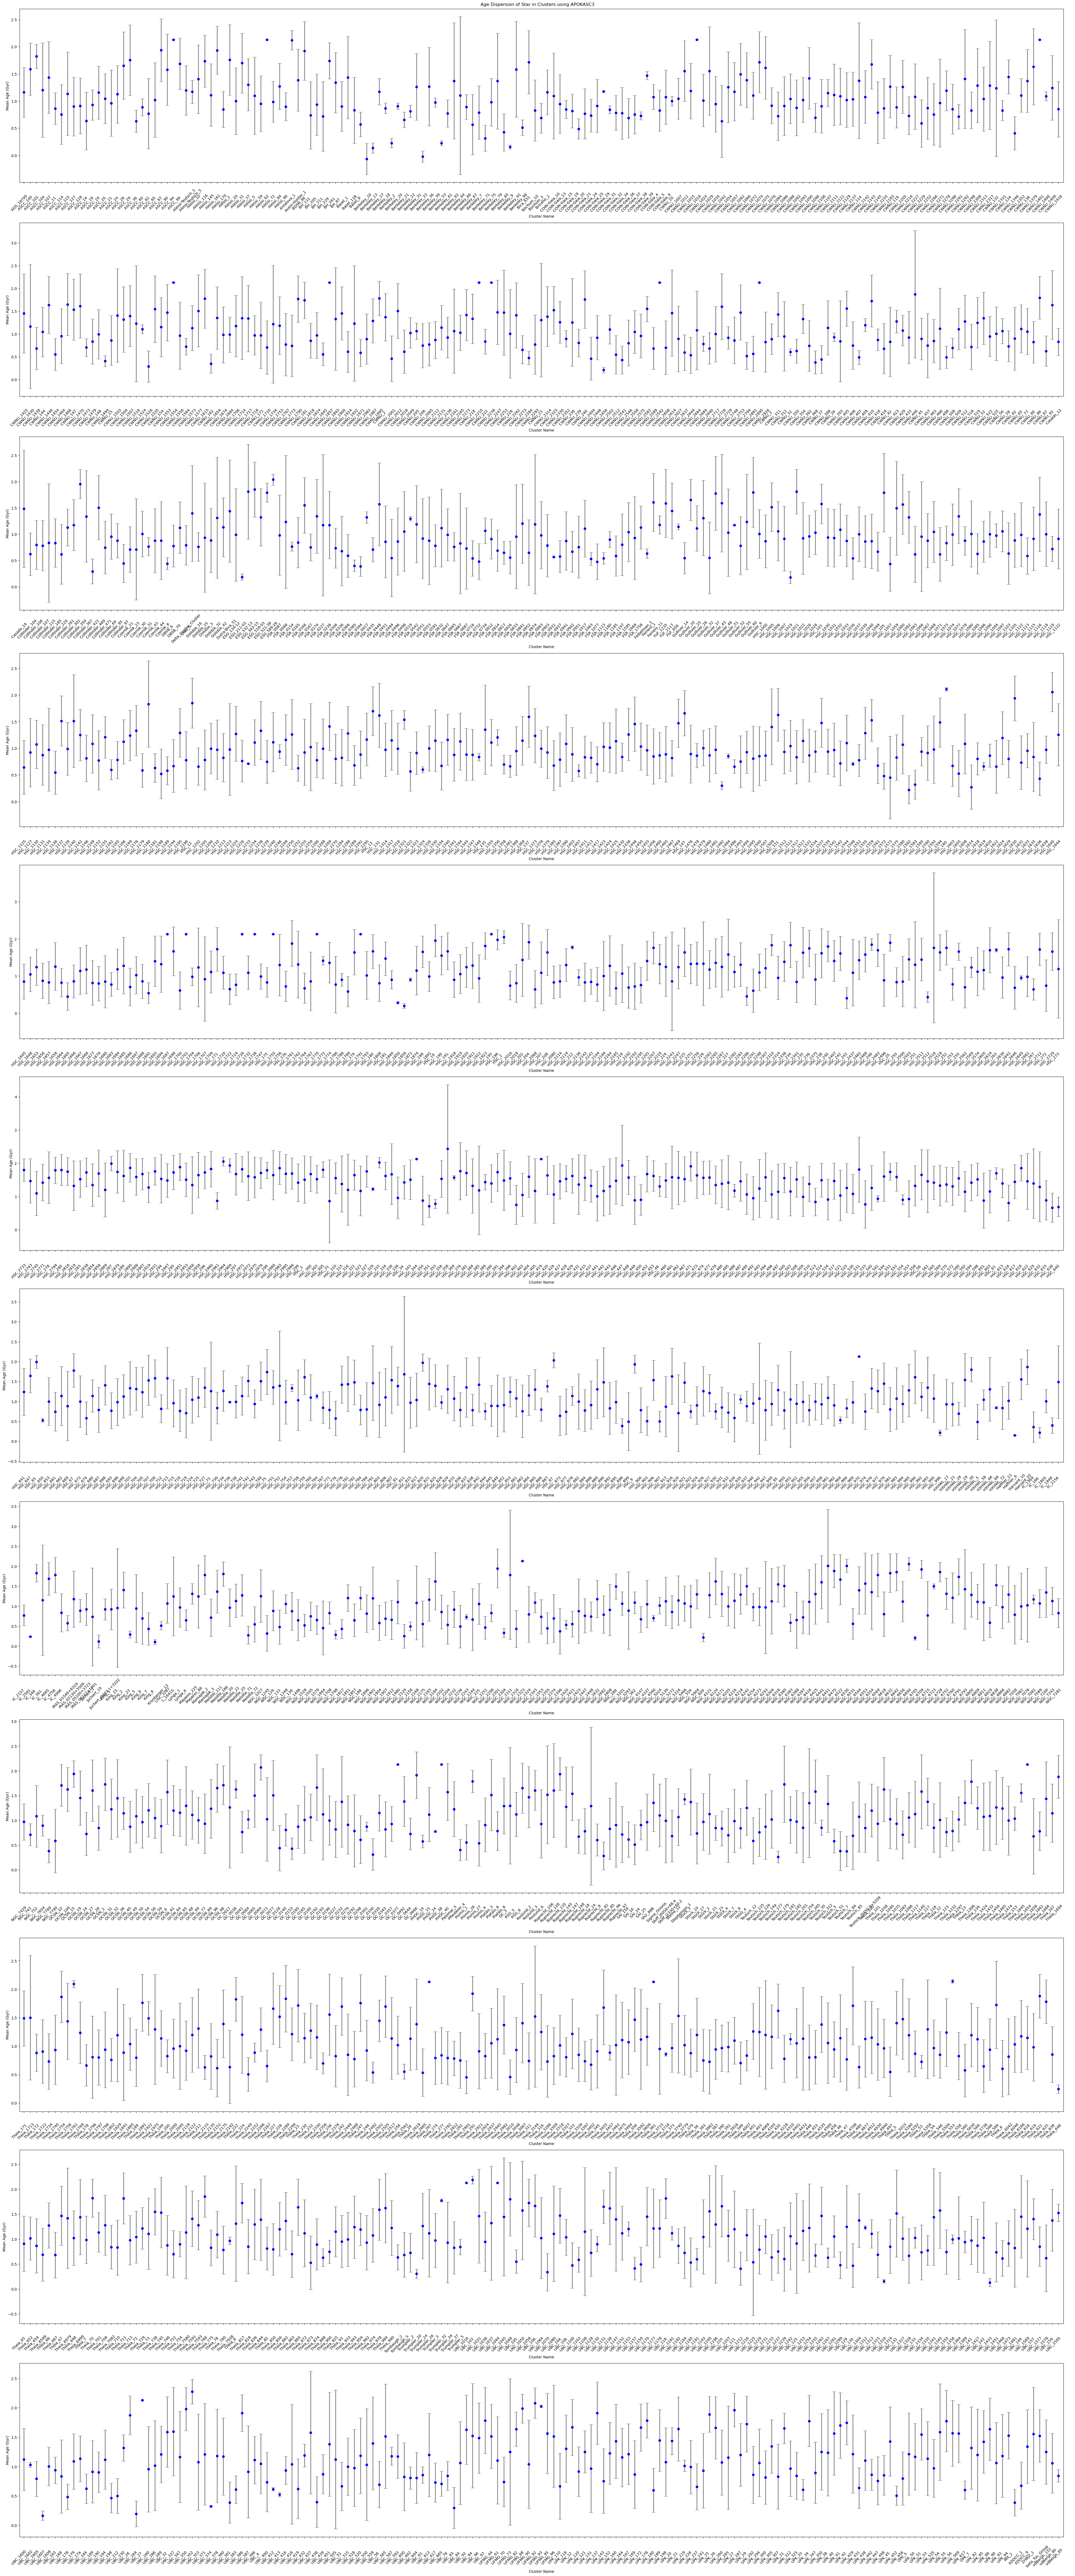

In [18]:
plot_maker(apokasc3_dispersion, 'APOKASC3')

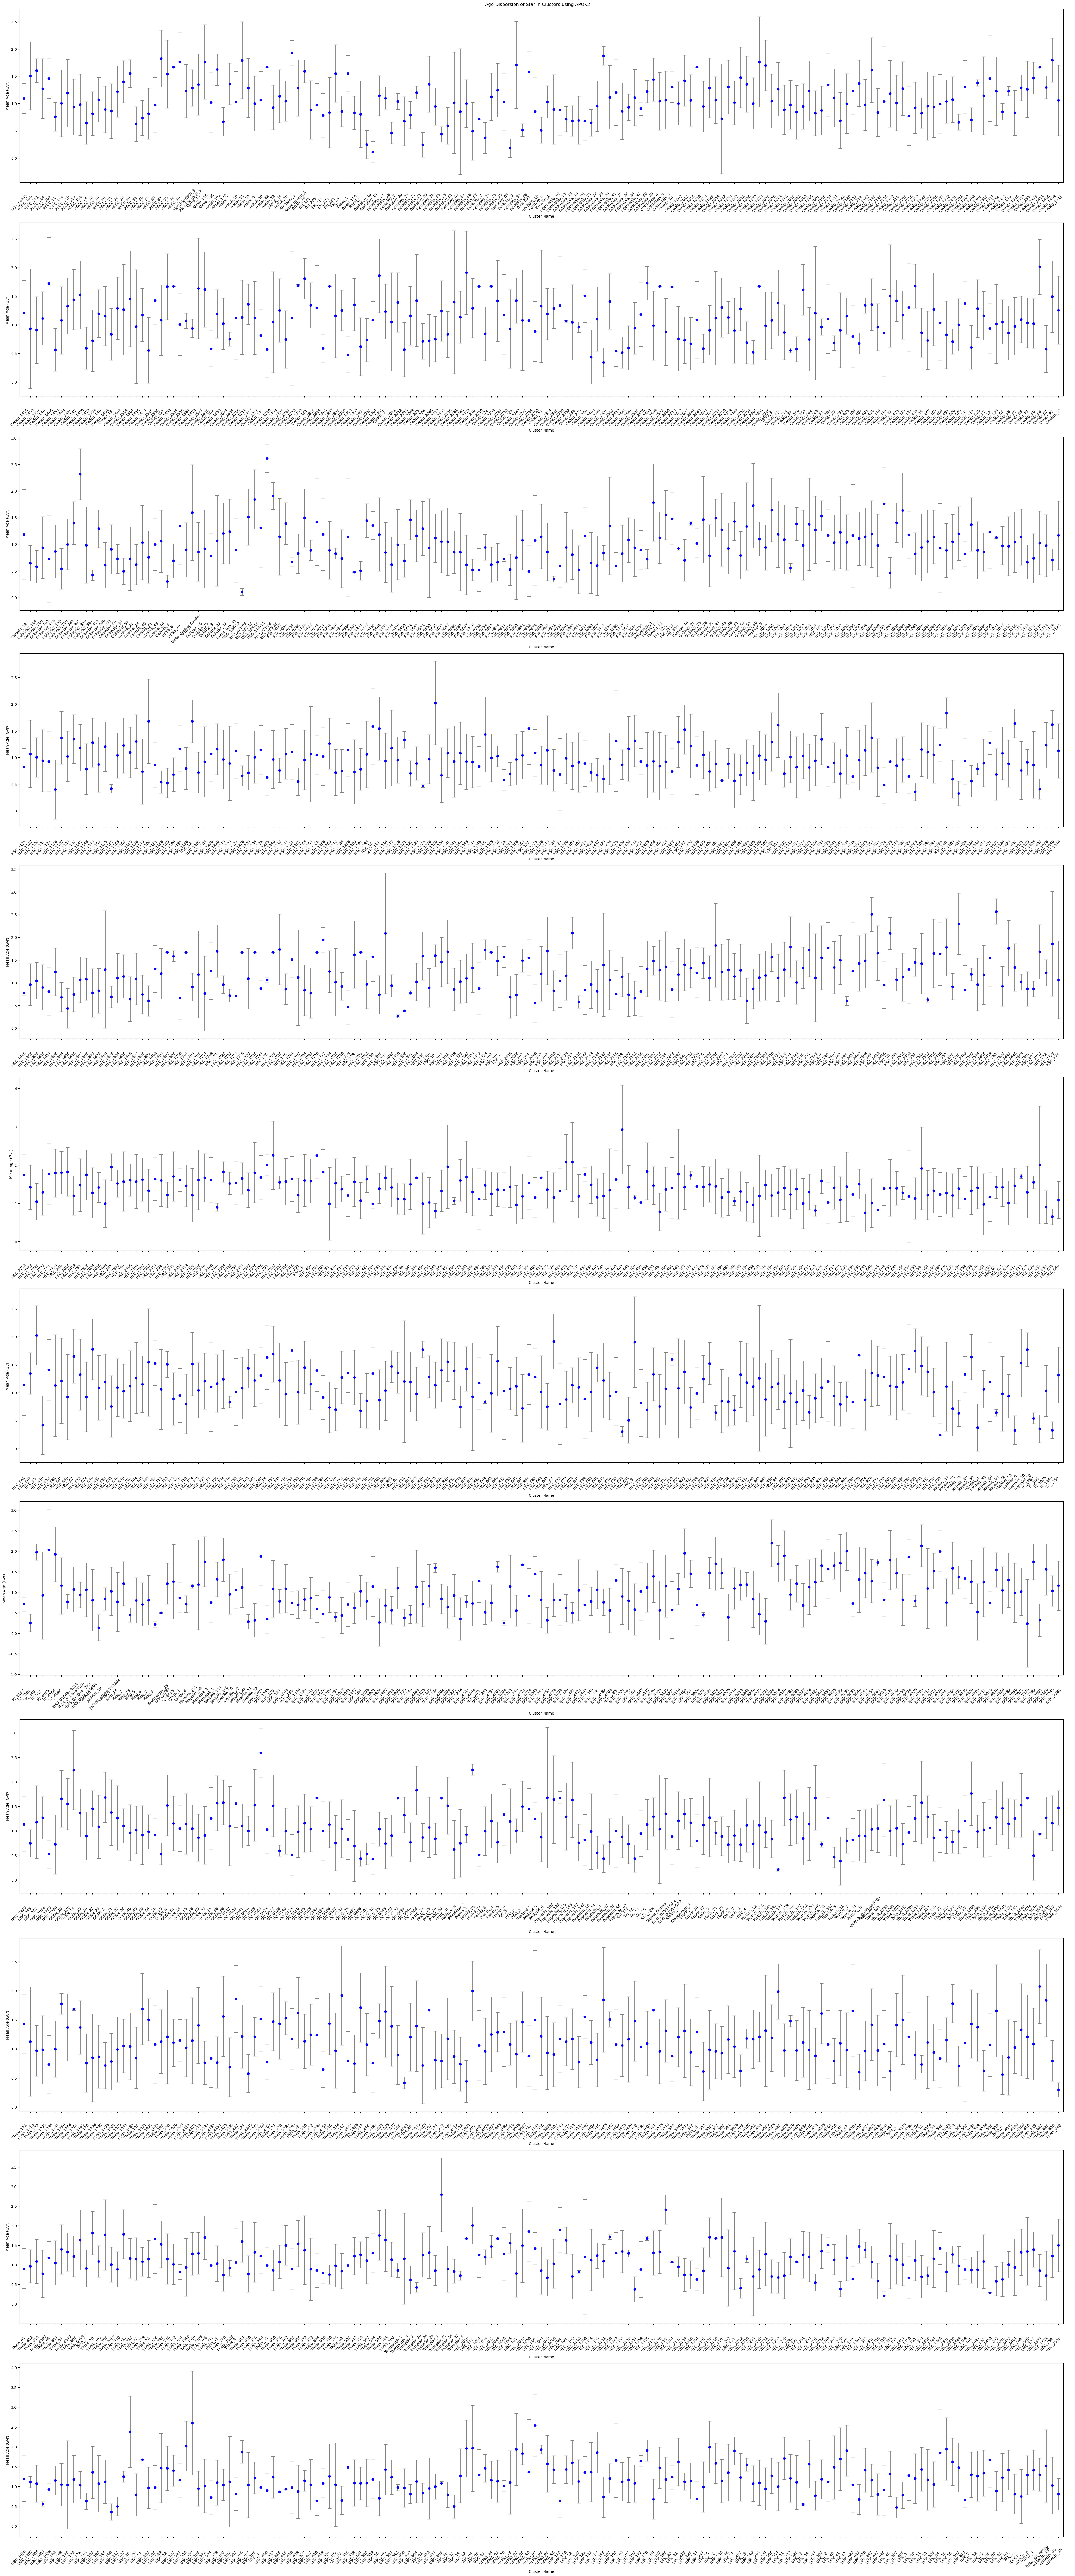

In [19]:
plot_maker(apok2_dispersion, 'APOK2')